# Personalization: Theory & Application

### Homework 2 Report
####  Name: Lehui Liu ( ll3238 ), Yinheng Li ( yl4039 )

## 1. Introduction
Steam is a popular gaming platform developed by Valve Corporation for purchasing and playing video games. In this project, we are trying to build a recommendation system for Steam based on a dataset containing users’ shopping and gaming history. The goal of this recommendation system is to help Steam platform better place advertisements for target users. In the meantime, it can also help Steam users discover new video games to their taste. Furthermore, we hope our model can provide some insights of user preference and clustering in their choices of games.

## 2. Dataset Overview
The dataset is stored in json format, and here is a glimpse of the dataset:  
{'user_id': '76561197970982479', 
'items_count': 2, 
'steam_id': '76561197970982479', 
'user_url': 'http://steamcommunity.com/profiles/76561197970982479', 
'items': [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}} 

This dataset contains 10978 users, 70912 items and 5153209 purchase & gaming records in total. To load the dataset, we need to reorganize it into user-item pairs. Since user_id and item_id is unique, we consider “steam_id”, “user_url” and “item_name” as redundant information and we exclude them. Meanwhile, we reassign an ID to each user and item to avoid IDs being too sparse. Here is what our data look like after reorganization.
<img src = 'img/dataset.png'>

For building a simple recommendation model, we only use the record user-item pairs rather than their specific playing times. Then our data looks like this:
<img src='img/datahead.png'>

Due to the limitation of our computing power, we can only work on a small sample of the dataset. So, we sample 3000 users (out of 10978) in random from the original dataset, and this new dataset ends up being the exact dataset we use in our model.   
Next, we are going to user two different approaches to build the recommendation system: 
1. Memory based: K-Nearest Neighbor ( Please see KNN.ipynb in the repo)   
2. Model based: Matrix Factorization ( Please see MF.ipydb in the repo )  

Then we compare the performance of these two approaches and discuss the drawbacks of each model.


## 3. KNN
### 3.1 Model setup

Given a dataset for user-item pairs, it is easy to come up with a memory-based collaborative filtering model. In this project, I am going to make users as vectors, and calculate the similarity between each user vectors. A sparse matrix containing user vectors may look like this:

|  | Item 1 | Item 2 | Item 3 | ··· | Item M|
| --- | --- | --- | --- | --- | --- |
| User 1 |  0  |  1  |  0  |  ···  |  1  |
| User 2 |  0  |  1  |  0  |  ···  |  1  |
|  ···   |  0  |  1  |  0  |  ···  |  1  |
| User N |  0  |  1  |  0  |  ···  |  1  |

If user i has consumed item j, the (i, j)th entry in the matrix will be 1, otherwise 0. This matrix is very sparse, so we store it using package “scipy.sparse”. The similarity of user vectors is defined to be the cosine between two vectors:  
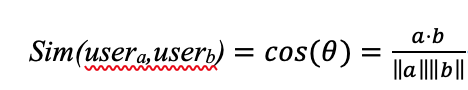

Based on the similarity between each vector, the predicted value for user u at item t is calculated using the following formula:  
$${\hat{r}}_{ut}=\frac{\sum_{i\in u}\left(Sim{\left(i,t\right)\cdot r_{it}}\right)}{\sum_{i\in u}\left|Sim{\left(i,t\right)}\right|}$$

  
Since the value in the matrix can either be 1 or 0, we set a benchmark for $\hat{r}_{ut}$. If $\hat{r}_{ut}$ > benchmark, let $\hat{r}_{ut}$ = 1, otherwise 0. The benchmark value has to be between 0 and 1. When the benchmark is close to 0, our prediction is very aggressive. As long as there is a small probability that the user like the item, we recommend it immediately. On the other hand, then the benchmark is close to 1, our prediction is very conservative, we only recommend items we are very sure that the user will like. We expect that a small benchmark will produce a high recall while a large benchmark will produce a high precision. Since the user matrix is extremely sparse and most of our prediction end up being 0, there is no point choosing a fixed N items for recommendation. However, the benchmark can be used as a flexible hyperparameter to adjust our recommendation size. In the next section, we will present how this hyperparameter influence the model performance.

### 3.2 Model Evaluation

To evaluate the model, we use Monte Carlo cross-validation. Each time we sample 70% item from each user as the training data, and the left 30% is the testing data. We report the following parameters in each round of cross-validation, and they are defined as below:

let S(t) be the set of t recommended items for a user u, G be the true relevant set that was consumed, T be the true relevant training set for this user:

Error: $$e_u=1-\frac{|\left(s\left(t\right)\setminus T\right)\cap G|}{|\left(s\left(t\right)\setminus T\right)\cup G|}$$

Precision: $$ P_u=\frac{|\left(s\left(t\right)\setminus T\right)\cap G|}{|\left(s\left(t\right)\setminus T\right)|}$$

Recall: $$R_u=\frac{|\left(s\left(t\right)\setminus T\right)\cap G|}{|G|}$$

Coverage:  $$C_u=1_{\left|\left(s\left(t\right)\setminus T\right)\cap G\right|\geq k}$$


For the entire training set, we simply calculate the average of precision, recall and coverage. We also calculate the RMSE based on each user. While doing cross validation, we also change different benchmarks. Here’s the result for 5 rounds validation with benchmark from 0 to 0.5.

<img src = 'img/samplesize.png'>
<img src = 'img/trainresult.png'>
<img src = 'img/trainplot.png'>

As can be seen, a lower benchmark produces a higher recall and coverage while a higher benchmark produces a higher precision. This observation confirms our previous expectation. The best recall and precision value are around 0.5, which is acceptable. However, the RMSE is very large which indicates that the model can be improved. This graph also suggests us to take a benchmark=0.2 to get a relatively small error. Surprisingly, at this benchmark the precision curve and the recall curve cross each other. So, choosing this point we will get a rather moderate recall and precision. 

In terms of scaling, we produce the following three graphs with user size=30, 300, 3000:

Usersize = 30:
<img src = 'img/usersize30.png'>
Usersize = 300:
<img src = 'img/usersize300.png'>
Usersize = 3000:
<img src = 'img/usersize3000.png'>

As can be seen from these three graphs, when the size of user varies, the main pattern of the model performance remains the same, which means the overall accuracy remains the same. However, as the size of user getting larger and larger, all the curves in the graph becomes smoother and smoother. In addition, the running time also increases with the increase of sample size.

### 3.3 Potential Improvent

There are many changes we can make to improve the model. Some of them will be implemented in our final project. For this specific model, we can change the way we calculate similarity. Instead of using cosine similarity, we can learn the similarity based on the training sample. Meanwhile, user vectors are very sparse in our dataset. So, we can change to using item as a vector, which may produce better results. For a more general model, we can use the “playtime” feature provided in the original dataset. In this case, we can weight more on items (games) that the player spends more time on, and we can produce a ranked recommendation. 

## 4. Matrix Factorization
### 4.1 Model Setup
We resample the data through randomly choose a unique user set of 20000 users and a unique item set of 150 items. Then the sample should be the intersection of these two sets. It turns out that we have 10692 users and 130 items. 
Thus the size of the sparse matrix we use is of 10692 * 130 with 26592 stored elements.
At first, we choose latent dimension equals 50. 
We adopt SVD in scipy package as our matrix factorization algrithm.
Thus, the dimension of item_factor and user_factor we get after factorization is (50, 130)
(10692, 50).


### 4.2 Model Evaluation
For cross validation, we run a 5-fold CV. We first randomly split the dataset into 5 parts of the same size. During each time, we use a part as the validation set and the remaining 4 parts as the training set.
For the training metrics, we adopt **Recall** and **Precision** as our metrics.


### 4.3 Hyper parameters

For hyper parameters in this algorithms, we have the latent dimension, the Top **K** elements we recommend to the user and the sample size. We systematically choose a set of hyper parameters to do the cross validation.
In the following setting, we recommend the top 10 items related to the user,i.e. **K** = 10.


For hyper parameters in this algorithms, we have the latent dimension, the Top K elements we recommend to the user and the sample size. We systematically choose a set of hyper parameters to do the cross validation.
In the following setting, we recommend the top 10 items related to the user.


First, we choose a set of latent dimenison of (1,2,3,4,5,6,7,8,9,10,15,20) as the latent dimension.
we then plot the result.  
<img src = 'img/item120.png'>



From the plot above, we can see that when item size is relatively small, we can choose the latent dimension equal to 1.

While we systematically increase the sample size.  
Let sample size users  = 20000,items = 1000.  
After resample, we get unique items = 869.
<img src = 'img/item869.png'>

As we see, under different sample size, the best latent dimension we choose may vary, in this case, we choose 2 as our latent dimension.

### 4.4 Potential Improvement

For this model, we only choose svd method as our matrix factorization algorithm. There are many other algorithm we can choose to explore, such as ALS, LightFM, etc.  
Besides, we have many side information in the dataset,such as user reviews,play time, which can all be used in our final project.


## 5. Conclusion
### 5.1 Comparison & Objective

In this project, we choose KNN and matrix factorization as our model to build a recommender system from scretch without using external packages except numpy,scipy and pandas.  
From the result, we can see that KNN performs well under a small dataset with high performance while matrix factorization model shows a better result on recall rate and better running time.  
Recall that our goal is to recommmend steam games to users, We can derive this goal into two parts that can be tackled with these two algorithm.    
First, Users like you also plays games. In this case, since we explored the similarity between two users, we can confidently recommmend the games to users by KNN.  
Second, if a user paticularly like a genre of game, we can use matrix factorization method since we can explore the latent genre of games in a latent dimension.

### 5.2 Potential Problem & Improvement
**Problems:**    
We sample data intuitively. Followed up, we simply choose a random subset of large dataset. While in this setting, some games can never be recommended.    
**Improvement:**  
For KNN model, we can try different ways to define similarity and item-based KNN instead.  
For matrix factorizaiton model, we can try different models, such as LightFM, ALS and use other package like Spark which can accelerate the speed of factorization.  
Futhermore, we have side information in the dataset such as users reviews, playtime_forever, playtime_2weeks. With these information, we can develop a more personalized system.  